# Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial - Inteligencia Artificial para Juegos (Game IA) - Sesión 1 - Tarea

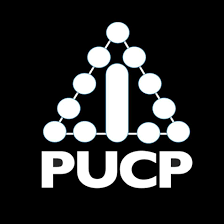
<img src='https://dci.pucp.edu.pe/wp-content/uploads/2014/02/logo-color-pucp1.gif' width=200px>

PhD. Edwin Villanueva, BSc. Daniel Saromo

<font color='orange'>Agente aspirador en una grilla a colores de MxN</font>

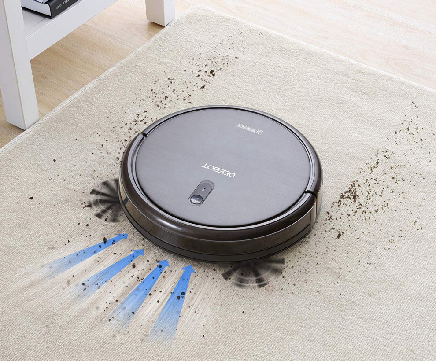

En el presente notebook se tiene la codificación de un agente aspirador (`VacuumAgent`) así como de un entorno gráfico tipo grilla configurable (`room`). Se busca que el agente interactúe con su entorno para limpiarlo.

**IMPORTANTE**

Completar con su código los campos requeridos y subir su notebook solucionado a la plataforma PAIDEIA. El formato del nombre del notebook es: `Desafio1_APELLIDOPATERNO_NOMBRE.ipynb`.

Es responsabilidad del alumno verificar que el archivo que subió es el correcto. Respetar los lineamientos de la entrega de archivo, ya que influirá en su calificación. La fecha límite de entrega del presente desafío se encuentra en PAIDEIA.

Importante: definir los siguientes 4 elementos.

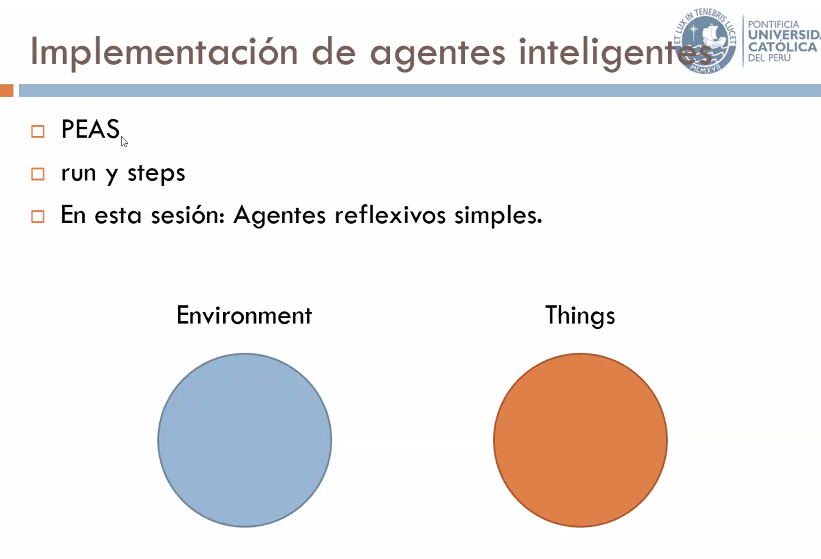

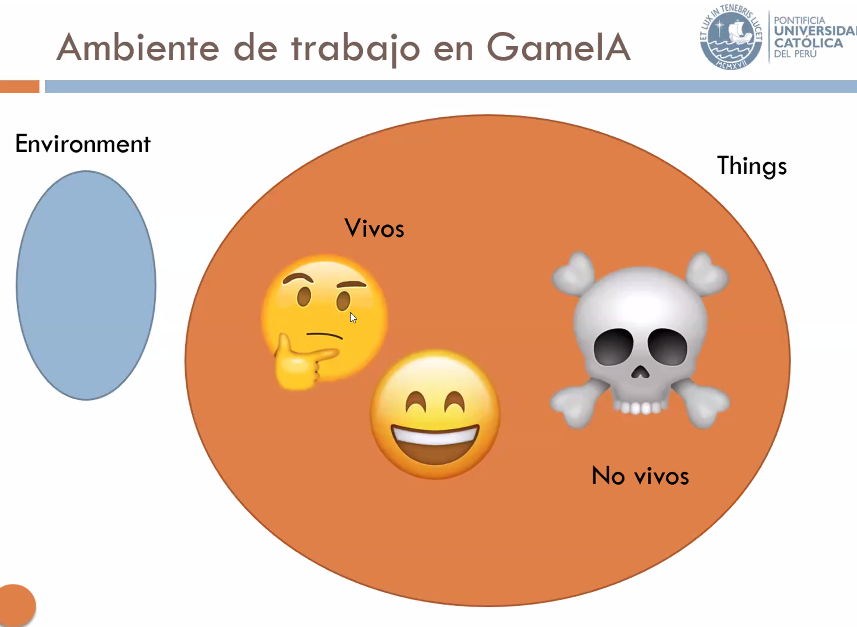

La carita que está pensando es el agente. La que está FELIZ es un NPC: Non Perceptible Character (caracter que no percibe).

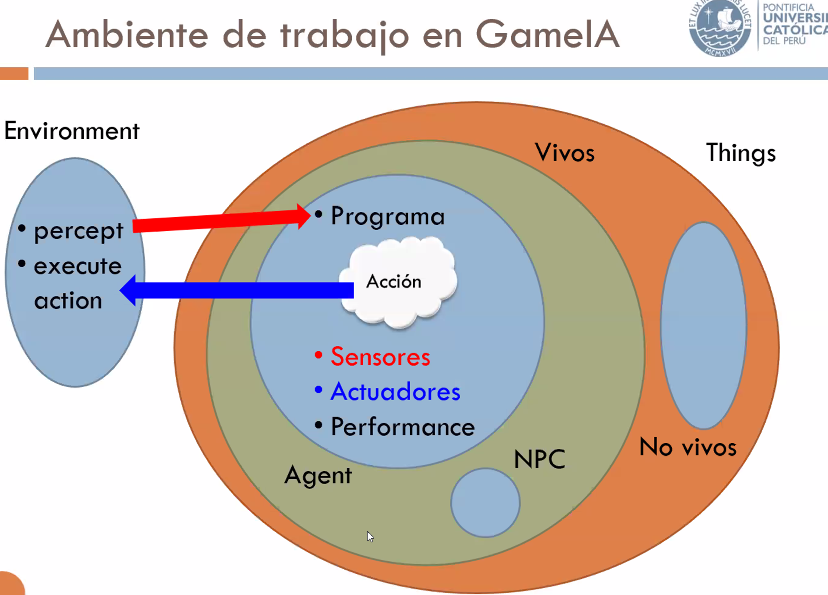

### El entorno condiciona al agente!

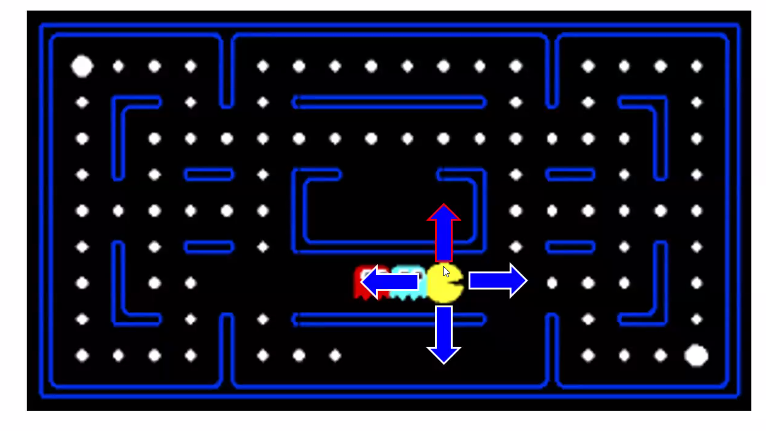

Según lo de arriba (agente, NPC, no vivo).

Puntitos: No vivo.
Fantasmas: NPC o un agente (dependiendo cómo esté implementado)
Agente: packman(amarillo)


## Clase <b>Thing</b>

  Esta clase generica representa cualquier objeto fisico que puede aparecer en un <b>Ambiente</b>.

In [1]:
class Thing(object):

    def is_alive(self):
        """Cosas 'vivas'deben retornar true."""
        return hasattr(self, 'alive') and self.alive

    def show_state(self):
        """Muestra el estado interno del agente. Subclases deben sobreescribir esto."""
        print("I don't know how to show_state.")

## Clase <b>Agent</b>

Un agente es una subclase de Thing con un slot obligatorio: <b>.program</b>, el cual almacena la funcion que implementa el <b>programa del agente</b>. Esta funcion debe tomar como argumento la <b>percepcion</b> del agente y debe retornar una <b>accion</b>. La definicion de Percepcion y Accion depende del ambiente de trabajo (environment) donde el agente existe. El agente tambien puede tener el slot <b>.performance</b>, que mide el desempeño del agente en su ambiente.

In [2]:
import collections

class Agent(Thing):

    def __init__(self, program=None):
        self.alive = True
        self.performance = 0
        assert isinstance(program, collections.Callable)
        self.program = program

## Clase <b>Environment</b>

Esta clase abstracta representa un entorno de tareas. Clases de entornos reales heredan de esta. En un entorno tipicamente se necesitará implementar 2 cosas:
<b>percept</b>, que define la percepción que el agente ve; y 
<b>execute_action</b>, que define los efectos de ejecutar una acción. 
El entorno mantiene una lista de .things y .agents (el cual es un subconjunto de .things). Cada elemento de .things tiene un slot .location. (No editar)

In [3]:
class Environment(object):

    def __init__(self):
        self.things = []
        self.agents = []

    def thing_classes(self):
        return []  # List of classes that can go into environment

    def percept(self, agent):
        """Retorna la percepcion que el agente 'agent' ve en este punto."""
        raise NotImplementedError

    def execute_action(self, agent, action):
        """El agente 'agent' ejecuta una accion 'action' en el entorno."""
        raise NotImplementedError

    def default_location(self, thing):
        """Localización por defecto para colocar una nueva cosa sin localizacion especificada."""
        return None

    def is_done(self):
        """Retorna True si no hay ningun agente vivo"""
        return not any(agent.is_alive() for agent in self.agents)

    def add_thing(self, thing, location=None):
        """Añade un objeto Thing al entorno en la localizacion location. 
           Si thing es un programa de agente, crea un nuevo agente con ese programa."""
        if not isinstance(thing, Thing):
            thing = Agent(thing)
        assert thing not in self.things, "No añade la misma cosa dos veces"
        thing.location = location if location is not None else self.default_location(thing)
        self.things.append(thing)
        if isinstance(thing, Agent):
            thing.performance = 0
            self.agents.append(thing)
    
    def delete_thing(self, thing):
        """Elimina un objeto Thing al entorno en la localizacion location
        Si thing es un programa de agente, igual lo remueve.
        Remove a thing from the environment."""
        try:
            self.things.remove(thing)
        except ValueError as e:
            print(e)
            print("  in Environment delete_thing")
            print("  Thing to be removed: {} at {}".format(thing, thing.location))
            print("  from list: {}".format([(thing, thing.location) for thing in self.things]))
        if thing in self.agents:
            self.agents.remove(thing)

    def list_things_at(self, location, tclass=Thing):
        """Return all things exactly at a given location."""
        return [thing for thing in self.things
                if thing.location == location and isinstance(thing, tclass)]

    def step(self):
        """Ejecuta un paso del entorno (llama a los programas de los agentes, 
        obtiene sus acciones y las ejecuta).| para cada uno de los agentes """
        if not self.is_done():
            actions = []
            for agent in self.agents:
                if agent.alive:
                    actions.append(agent.program(self.percept(agent)))
                else:
                    actions.append("")
            for (agent, action) in zip(self.agents, actions):
                self.execute_action(agent, action)

    def run(self, steps=1000):
        """Ejecuta steps pasos en el entorno."""
        for step in range(steps):
            if self.is_done():
                return
            self.step()

## Clase XYEnvironment

Grilla 2d X/Y

In [4]:
class XYEnvironment(Environment):
    """This class is for environments on a 2D plane, with locations
    labelled by (x, y) points, either discrete or continuous.

    Agents perceive things within a radius. Each agent in the
    environment has a .location slot which should be a location such
    as (0, 1), and a .holding slot, which should be a list of things
    that are held.
    Es una grilla 2 dimensional X/Y.
    """

    def __init__(self, width=10, height=10):
        super().__init__()

        self.width = width
        self.height = height
        self.observers = []
        # Sets iteration start and end (no walls).
        self.x_start, self.y_start = (0, 0)
        self.x_end, self.y_end = (self.width, self.height)

    perceptible_distance = 1

    def things_near(self, location, radius=None):
        """Return all things within radius of location."""
        if radius is None:
            radius = self.perceptible_distance
        radius2 = radius * radius
        return [(thing, radius2 - distance_squared(location, thing.location))
                for thing in self.things if distance_squared(
                                                location, thing.location) <= radius2]

    def percept(self, agent):
        """By default, agent perceives things within a default radius."""
        return self.things_near(agent.location)

    def execute_action(self, agent, action):
        agent.bump = False
        if action == 'TurnRight':
            agent.direction += Direction.R
        elif action == 'TurnLeft':
            agent.direction += Direction.L
        elif action == 'Forward':
            agent.bump = self.move_to(agent, agent.direction.move_forward(agent.location))
#         elif action == 'Grab':
#             things = [thing for thing in self.list_things_at(agent.location)
#                     if agent.can_grab(thing)]
#             if things:
#                 agent.holding.append(things[0])
        elif action == 'Release':
            if agent.holding:
                agent.holding.pop()

    def default_location(self, thing):
        return (random.choice(self.width), random.choice(self.height))

    def move_to(self, thing, destination):
        """Move a thing to a new location. Returns True on success or False if there is an Obstacle.
        If thing is holding anything, they move with him."""
        thing.bump = self.some_things_at(destination, Obstacle)
        if not thing.bump:
            thing.location = destination
            for o in self.observers:
                o.thing_moved(thing)
            for t in thing.holding:
                self.delete_thing(t)
                self.add_thing(t, destination)
                t.location = destination
        return thing.bump

    def add_thing(self, thing, location=(1, 1), exclude_duplicate_class_items=False):
        """Add things to the world. If (exclude_duplicate_class_items) then the item won't be
        added if the location has at least one item of the same class."""
        if (self.is_inbounds(location)):
            if (exclude_duplicate_class_items and
                    any(isinstance(t, thing.__class__) for t in self.list_things_at(location))):
                return
            super().add_thing(thing, location)

    def is_inbounds(self, location):
        """Checks to make sure that the location is inbounds (within walls if we have walls)"""
        x, y = location
        return not (x < self.x_start or x > self.x_end or y < self.y_start or y > self.y_end)

    def random_location_inbounds(self, exclude=None):
        """Returns a random location that is inbounds (within walls if we have walls)"""
        location = (random.randint(self.x_start, self.x_end),
                    random.randint(self.y_start, self.y_end))
        if exclude is not None:
            while(location == exclude):
                location = (random.randint(self.x_start, self.x_end),
                            random.randint(self.y_start, self.y_end))
        return location

    def delete_thing(self, thing):
        """Deletes thing, and everything it is holding (if thing is an agent)"""
        if isinstance(thing, Agent):
            for obj in thing.holding:
                super().delete_thing(obj)
                for obs in self.observers:
                    obs.thing_deleted(obj)

        super().delete_thing(thing)
        for obs in self.observers:
            obs.thing_deleted(thing)

    def add_walls(self):
        """Put walls around the entire perimeter of the grid."""
        for x in range(self.width):
            self.add_thing(Wall(), (x, 0))
            self.add_thing(Wall(), (x, self.height - 1))
        for y in range(1, self.height-1):
            self.add_thing(Wall(), (0, y))
            self.add_thing(Wall(), (self.width - 1, y))

        # Updates iteration start and end (with walls).
        self.x_start, self.y_start = (1, 1)
        self.x_end, self.y_end = (self.width - 1, self.height - 1)

    def add_observer(self, observer):
        """Adds an observer to the list of observers.
        An observer is typically an EnvGUI.

        Each observer is notified of changes in move_to and add_thing,
        by calling the observer's methods thing_moved(thing)
        and thing_added(thing, loc)."""
        self.observers.append(observer)

    def turn_heading(self, heading, inc):
        """Return the heading to the left (inc=+1) or right (inc=-1) of heading."""
        return turn_heading(heading, inc)
# ______________________________________________________________________________

## Clases Obstacle and Wall

In [5]:
class Obstacle(Thing):
    """Something that can cause a bump, preventing an agent from
    moving into the same square it's in."""
    pass

class Wall(Obstacle):
    pass

## Clase GraphicEnvironment

In [6]:
#@title Instalacion de `ipythonblocks`
!pip install ipythonblocks
#interfaz gráfica de una grilla que puede ser coloreada 

In [7]:
from ipythonblocks import BlockGrid
from IPython.display import HTML, display
from time import sleep
class GraphicEnvironment(XYEnvironment):
  """
  Interfaz gráfica de XYEnvironment
  """
    def __init__(self, width=10, height=10, color={}, boundary=True, display=False):
        """Define all the usual XYEnvironment characteristics,
        but initialise a BlockGrid for GUI too."""
        super().__init__(width, height)
        self.grid = BlockGrid(width, height, fill=(200, 200, 200))
        if display:
            self.grid.show()
            self.visible = True
        else:
            self.visible = False
        self.bounded = boundary
        self.colors = color

    def get_world(self):
        """Returns all the items in the world in a format
        understandable by the ipythonblocks BlockGrid."""
        result = []
        x_start, y_start = (0, 0)
        x_end, y_end = self.width, self.height
        for x in range(x_start, x_end):
            row = []
            for y in range(y_start, y_end):
                row.append(self.list_things_at([x, y]))
            result.append(row)
        return result

    """
    def run(self, steps=1000, delay=1):
        "" "Run the Environment for given number of time steps,
        but update the GUI too." ""
        for step in range(steps):
            sleep(delay)
            if self.visible:
                self.reveal()
            if self.is_done():
                if self.visible:
                    self.reveal()
                return
            self.step()
        if self.visible:
            self.reveal()
    """

    def run(self, steps=10, delay=1):
        """Run the Environment for given number of time steps,
        but update the GUI too."""
        for step in range(steps):
            self.update(delay)
            if self.is_done():
                break
            self.step()
        self.update(delay)

    def update(self, delay=1):
        sleep(delay)
        if self.visible:
            self.conceal()
            self.reveal()
        else:
            self.reveal()

    def reveal(self):
        """Display the BlockGrid for this world - the last thing to be added
        at a location defines the location color."""
        self.draw_world()
        self.grid.show()
        self.visible = True

    def draw_world(self):
        self.grid[:] = (200, 200, 200)
        world = self.get_world()
        for x in range(0, len(world)):
            for y in range(0, len(world[x])):
                if len(world[x][y]):
                    self.grid[y, x] = self.colors[world[x][y][-1].__class__.__name__]

    def conceal(self):
        """Hide the BlockGrid for this world"""
        self.visible = False
        display(HTML(''))

## Clase VacuumEnvironment

In [8]:
#definimos las 4 localizaciones
loc_A, loc_B, loc_C, loc_D = [0, 0], [1, 0], [0, 1], [1, 1]   # The 4 locations for the Vacuum world 2x2

In [9]:
import random
class VacuumEnvironment(GraphicEnvironment):
    def __init__(self, width, height, color, autoDirt=False, boundary=True, display=False, verbose=False):
      super().__init__(width, height, color, boundary, display)
      #booleano: si cada una de las casillas va a ser ensuciada de forma aleatoria con cierta prob.
      self.autoDirt = autoDirt
      
      #modificar para el desafío (está en porcentajes)
      self.probAutoDirt = 10 #valor de probabilidad para que esté sucio | modificable para el desafío
      
      self.verbose = verbose

    def set_probAutoDirt(self, probAutoDirt):
      self.probAutoDirt = probAutoDirt

    def thing_classes(self):
      """List of classes that can go into environment."""
      return [VacuumBot]

    def percept(self, agent):
      '''return a list of things that are in our agent's location'''
      things = self.list_things_at(agent.location)
      return things

    def execute_action(self, agent, action):
      """Implementa el MAPA DE TRANSICIÓN: Cambia la posicion del agente y/o el estado de la posicion; 
      Cada aspiracion (acción 'Suck') en una localizacion Dirt provoca un aumento de desempeño en 10 unidades.
      Cada movida efectiva Right, Left, Up o Down provoca una disminución de desempeño en 1 unidad """

      if(self.verbose): print("********************************************************************")

      if action == 'Right':
        if(self.verbose): print("Agente se va a mover hacia la derecha")
        pos_act = agent.location.copy()
        pos_act[0] = pos_act[0] + 1 #pos_act[0]: dimension del agente
        agent.location = pos_act
        agent.performance -= 1
          
      elif action == 'Left':
        if(self.verbose): print("Agente se va a mover hacia la izquierda")
        pos_act = agent.location.copy()
        pos_act[0] = pos_act[0] - 1
        agent.location = pos_act
        agent.performance -= 1

      elif action == 'Up':
        if(self.verbose): print("Agente se va a mover hacia arriba")
        pos_act = agent.location.copy()
        pos_act[1] = pos_act[1] - 1
        agent.location = pos_act
        agent.performance -= 1

      elif action == 'Down':
        if(self.verbose): print("Agente se va a mover hacia abajo")
        pos_act = agent.location.copy()
        pos_act[1] = pos_act[1] + 1
        agent.location = pos_act
        agent.performance -= 1

      elif action == 'Suck':
        items = self.list_things_at(agent.location, tclass=Dirt)
        if len(items) != 0:
          if(self.verbose): print("Quiero limpiar las dirts", items, "en",agent.location)
          for i in items:
            if agent.clean(i): #Have the robot clean the first item
              print('{} limpió {} en la ubicación: {}'
                    .format(str(agent)[1:-1], str(items[0])[1:-1], agent.location))
              self.delete_thing(i) #Delete it from the Room after.
        agent.performance += 10

      #Si es que self.autoDirt está activado, aleatoriamente va a ensuciar las casillas vacias
      if(self.autoDirt==True):
        world = self.get_world()
        for x in range(0, len(world)):
          for y in range(0, len(world[x])):
            if (  len( self.list_things_at([x, y]) ) == 0  ):
              #if(self.verbose): print("Estoy queriendo ensuciar en esta casilla vacía:",x,y)
              dirt = Dirt()
              numMovil = random.choice(list(range(0,100)))
              if (numMovil < self.probAutoDirt):#probabilidad de ensuciar cada casilla
                if(self.verbose): print("------> Acabo de ensuciar la casilla:",x,y)
                self.add_thing(dirt, [x, y])

    def default_location(self, thing):
        """Devuelve una posicion aleatoria para la posición inicial de la aspiradora."""
        x_random = random.choice(0,    len(world))
        y_random = random.choice(0, len(world[x]))
        return [x_random, y_random]

## Clase Dirt

In [10]:
class Dirt(Thing):
    pass

In [11]:
dirt = Dirt()
id(dirt)

140052069157408

In [12]:
dirt = Dirt()
id(dirt)

140052500979952

## Clase VacuumBot

In [13]:
#agente que va a vivir en el entorno
class VacuumBot(Agent):        
    def clean(self, thing):
        '''Retorna True si es que la limpieza fue satisfactoria y False en otros casos'''
        if isinstance(thing, Dirt):
            return True
        return False

## Definición de programas de agentes

**NOTA**: En la implementación, las coordenadas se representan como una lista con dos elementos: [`columna`, `fila`]. (no fila/columna como usualmente es, p.ejem, en un array).

En este caso, es una grila 4x4.

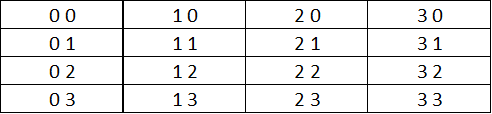

Recordemos que estas son las etiquetas de las coordenadas en un entorno 2x2.

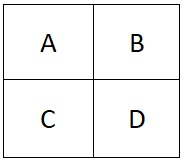

¿Cómo garantizo que un agente pueda mantener limpio un entorno `VacuumEnvironment` 2x2?

In [14]:
def program(percepts):
  #Si alguna de mis percepciones es un Dirt... debo limpiar
  #Puede que mi primera percepción no sea un Dirt!
  for pp in percepts:
    if isinstance(pp, Dirt):
      return 'Suck'


  #si no está sucio... Reflexivamente, le asigno una accion para cada posicion
  for pp in percepts:      
    if pp.location == loc_A:
      return 'Right'
    elif pp.location == loc_B:
      return 'Down'
    elif pp.location == loc_C:
      return 'Up'
    elif pp.location == loc_D:
      return 'Left'

In [15]:
class Dirt(Thing):
  #clase que representa la suciedad
    pass

In [16]:
dirt = Dirt()
id(dirt)

140052059690488

In [17]:
dirt = Dirt()
id(dirt)

140052059915376

## Creamos y probamos el entorno

Solamente para la interfaz gráfica con [ipythonblocks](http://www.ipythonblocks.org/), la representación de coordenadas es: [`fila`, `columna`]. Para más información, consulte el [código fuente](https://github.com/jiffyclub/ipythonblocks/blob/master/ipythonblocks/ipythonblocks.py#L55).

In [18]:
#defino un vacuumEnvironment de 3 columnas, 2 filas
#defino: color del objeto 'vacuumbot' en RGB (200,0,0) [rojo]
#defino: color del objeto 'dirt' (suciedad) en RGB (133, 122, 111) [gris]
#autoDirt: casillas seran aleatoriamente ensuciadas segun prob. dada
#verbose: False, dado que no se dará más detalle

room = VacuumEnvironment(3,2, 
                         color={
                             'VacuumBot': (200,0,0), 
                             'Dirt': (133, 122, 111)},
                          autoDirt=True, verbose=False) # room width is set to 2, and height to 2

#entregamos al agente el programa llamado 'program'.
#este programa es el definido previamente:
#gira en sentido horario en busca de visitar cada espacio
#y, de ese modo, asegurarse que todos los espacios sean visitados
#de estar sucios, por ende, limpiará: este es el 'def program'.
vacuumBot = VacuumBot(program)

#variables de suciedad inicial
dirt = Dirt()
moredirt = Dirt()

#agrego las funciones Dirt de 'suciedad' inicialmente
#nótese que esto se hace para empezar
#luego irá cambiando
#empieza en locación A y locación C

room.add_thing(dirt, loc_A)
room.add_thing(moredirt, loc_C)

In [19]:
#'get_world': obtengo todos los objetos de acuerdo a todas las casillas
#ejem, puedo agregar el vacuumbot en una locación en específica: ver sig.
#aqui todavia no hemos ingresado al agente vacuumbot
room.get_world()

[[[<__main__.Dirt at 0x7f6069480908>], [<__main__.Dirt at 0x7f607630b390>]],
 [[], []],
 [[], []]]

In [20]:
#agregamos el vacuumBot en una localización específica
#en este caso, localización C.

room.add_thing(vacuumBot, location=loc_C)

In [ ]:
#como puede ver, aparece el vacuumBot en la posicion señalada: C
#recuerde que en este caso todavia seguimos con la indexacion
#columna/fila (en el plot de las imagenes será fila/columna)
room.get_world()

In [21]:
#creo otro vacuumbot con el mismo programa
#porque puedo agregar más de uno al entorno!!!!!!!
vacuumBot2 = VacuumBot(program)

In [22]:
#este vaccuum bot es para la tarea, debemos agregar para que ambos chambeen!!!!
#room.add_thing(vacuumBot2, location=loc_B)

In [23]:
#cambio directo al atributo. existe otra manera de cambiar parámetros del entorno?

#activamos el verbose para ver internamente qué está pasando
#esta es una manera directa de cambiar el objeto/al atributo o ESTADO actual
#otra forma es a través de métodos que te permiten acceder a los parámetros internos
#p.ejem, a través de 'execute_action' podemos cambiar internamente los parámetros
#p.ejem, también através del método 'set_probAutoDirt' ingresando un valor numérico
#         y definimos así cuál es la probabilidad interna de ensuciarse con ese método
#         allí ocurre la re-definición del valor 10 inicial de autodir.
room.verbose=True  

In [24]:
room.get_world()

[[[<__main__.Dirt at 0x7f6069480908>],
  [<__main__.Dirt at 0x7f607630b390>, <__main__.VacuumBot at 0x7f6069480978>]],
 [[], []],
 [[], []]]

In [25]:
room.autoDirt=True #activamos autodir: seteo de probabildiad para cada accion segun valor asignado

¿Qué hará el agente? 

Moverse en sentido horario para limpiar. Esto garantiza que todas las casillas serán visitadas y, en caso estén sucias, limpiadas.

Haciendo uso de un entorno 2x2 tipo ABCD en la imagen anterior (funciona igual para entornos más grandes). 

**IMAGEN_CENTRAL**

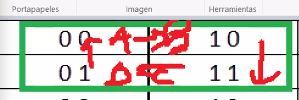

In [26]:
room.run(20) #iterado 20 veces
#vea cómo el agente inicia en la posición C
#pero esta posición C es la esquina inferior izquierda de la grilla 2x2
#esto a se debe que la interfaz gráfica es a la inversa ("swapeado")
#nótese que la base era la iamgen de arriba donde C era [1,1]
#esta diferencia es como un espejo:reflejo.

,,
,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f607630b390>] en [0, 1]
__main__.VacuumBot object at 0x7f6069480978 limpió __main__.Dirt object at 0x7f607630b390 en la ubicación: [0, 1]


,,
,,


********************************************************************
Agente se va a mover hacia arriba


,,
,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f6069480908>] en [0, 0]
__main__.VacuumBot object at 0x7f6069480978 limpió __main__.Dirt object at 0x7f6069480908 en la ubicación: [0, 0]


,,
,,


********************************************************************
Agente se va a mover hacia la derecha


,,
,,


********************************************************************
Agente se va a mover hacia abajo
------> Acabo de ensuciar la casilla: 2 0


,,
,,


********************************************************************
Agente se va a mover hacia la izquierda


,,
,,


********************************************************************
Agente se va a mover hacia arriba
------> Acabo de ensuciar la casilla: 1 1


,,
,,


********************************************************************
Agente se va a mover hacia la derecha


,,
,,


********************************************************************
Agente se va a mover hacia abajo


,,
,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f6069449be0>] en [1, 1]
__main__.VacuumBot object at 0x7f6069480978 limpió __main__.Dirt object at 0x7f6069449be0 en la ubicación: [1, 1]


,,
,,


********************************************************************
Agente se va a mover hacia la izquierda


,,
,,


********************************************************************
Agente se va a mover hacia arriba
------> Acabo de ensuciar la casilla: 0 1


,,
,,


********************************************************************
Agente se va a mover hacia la derecha


,,
,,


********************************************************************
Agente se va a mover hacia abajo


,,
,,


********************************************************************
Agente se va a mover hacia la izquierda


,,
,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f60839dcef0>] en [0, 1]
__main__.VacuumBot object at 0x7f6069480978 limpió __main__.Dirt object at 0x7f60839dcef0 en la ubicación: [0, 1]
------> Acabo de ensuciar la casilla: 1 0


,,
,,


********************************************************************
Agente se va a mover hacia arriba


,,
,,


********************************************************************
Agente se va a mover hacia la derecha
------> Acabo de ensuciar la casilla: 0 1


,,
,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f6069480128>] en [1, 0]
__main__.VacuumBot object at 0x7f6069480978 limpió __main__.Dirt object at 0x7f6069480128 en la ubicación: [1, 0]
------> Acabo de ensuciar la casilla: 2 1


,,
,,


********************************************************************
Agente se va a mover hacia abajo


,,
,,


In [27]:
vacuumBot.performance, vacuumBot2.performance

(35, 0)

Nota: en las casillas de arriba los index de los cuadraditos con el chart puesto a nivel teórico están invertidos.

## Para desarrollar

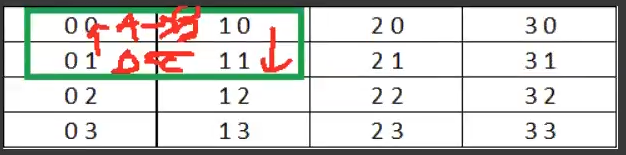

- Crear un entorno `room` de 4x4 de con dos agentes que se muevan de manera reflexiva. Se busca que puedan operar de forma autónoma. Las posiciones iniciales de los agentes deben ser diferentes entre sí. 

- Para ello se deben generar dos secuencias de agentes que, **_en conjunto_**, garanticen que todas las casillas del entorno se lleguen a limpiar constantemente. Mostrar la secuencia de pasos de dichos agentes reflexivos en una imagen similar a la desarrollada en Paint, mostrando la coreografía de ambos agentes en la grilla única de 4x4 (0.25 puntos). Coger la imagen que ya está arriba con la grilla 4x4. Si están trabajando en Jupyter, y no se puede incrustar la imagen en el notebook ipynb, tiene que adjuntar su imagen en su archivo de entrega. Dicho fichero sería ahora un comprimido con extensión `.rar`.

- Implementar dos programas de agentes, de acuerdo a las secuencias (rutas) propuestas en su imagen (0.25 puntos por cada programa de agente).

- Activar la generación aleatoria de `Dirt` en el entorno creado, y modificarlo para que cada casilla tenga una probabilidad del `20%` de ensuciarse (0.25 puntos). Esto implica cambiar la variable `self.probAutoDirt` de 10 a 20.

- **No** debe modificar la implementación del objeto `VacuumEnvironment`.

Recordar1: son 2 secuencias en total debido a que hay 2 agentes (una secuencia x agente).

Recordar2: los agentes pueden superponerse. Pero, ¿eso es bueno?

Recordar3: en cada iteración, el método 'step' le pasa las percepciones a cada agente; primero para el agente A, ejecuta su acción, se mueve, y luego para el agente B, ejecuta su acción y se mueve. 

Recordar 4: NO modificar el entorno. Solo modificar/crear el programa (método 'program').

Nota: los agentes pueden llegarse a superponer en un mismo cuadradito. No importa.

Agente reflexivo = Agente reactivo.

Reacciona ante una entrada.

Nota:  **CREAR EL PROGRAMA DEL AGENTE** ( _def program(percepts)_ ).

NO MODIFICAR EL ENTORNO.